# Reverse Arrangement Demo

The reverse arrangement test is commonly used in reliabilty engineering to detect 
trends in time series data, in a way where we don't need to suppose any sort parametric 
model.



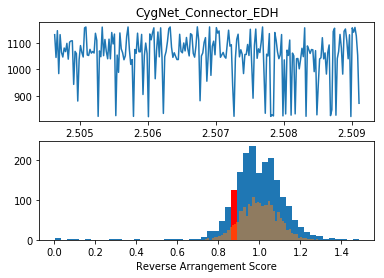

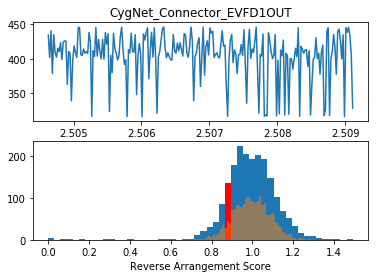

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
from numpy.random import rand
import matplotlib.pylab as plt

def RandSmpl(data, n_minutes, m_samples):
    for i in range(0, m_samples):
        indx = np.floor(rand(n_minutes//10) * data.shape[0] )
        smp = data.iloc[indx]       
        yield smp        

def RandSmplSeq(data, n_minutes, m_samples):
    rng = data.index[-1] - data.index[0]
    
    for i in range(0, m_samples):
        indx = rand() * rng + data.index[0]
        smp = data.loc[indx:indx+n_minutes]        
        yield smp        

def ReverseArrangement(smp, dirn=1):
    """
    smp assumed to be ordered
    """
    
    # "A" from the murray paper
    if dirn > 0:
        A = [ np.sum(smp.values[i+1:,:] > smp.values[i,:], axis=0) for i in range(0, smp.shape[0]-2)]
    else:
        A = [ np.sum(smp.values[i+1:,:] < smp.values[i,:], axis=0) for i in range(0, smp.shape[0]-2)]
                 
    return np.atleast_1d(np.sum(A, axis=0))
       
# assume its sorted
data = pd.read_csv("~/data/esp_data_one_month_10_minute_interval.csv")

# update index to minutes since epoch
index = np.array([(dt.datetime.strptime(i, "%m/%d/%y %H:%M") - 
                    dt.datetime(1970,1,1)).total_seconds()/60 for i in data['DateTime'] ], 
                       dtype=np.int64)
data.index = index
data.drop('DateTime', 1, inplace=True)

x = RandSmpl(data, 100, 3)
smp = list(x)[0]

RAseq = []
for i in RandSmpl(data, 600, 2000):
    x = ReverseArrangement(i,dirn=1)    
    if(len(x) == 21):
        RAseq.append(x)    
result_noseq = np.vstack(RAseq)


RAnoseq = []
for i in RandSmplSeq(data, 600, 2000):
    x = ReverseArrangement(i,dirn=1)
    if(len(x) == 21):
        RAnoseq.append(x)    
result_seq = np.vstack(RAnoseq)

# final 10-hours 
smp = data.iloc[-60:]
x = ReverseArrangement(smp)
last = x*4/(60.*59)

sensors = data.columns
for isensor in range(0, 2):
    sensor = sensors[isensor]

    fig, (ax1, ax2) = plt.subplots(2)
    
    ax1.plot(data[sensor][::20])
    ax1.set_title(sensor)
    #ax.set_xlabel('Mins since epoch')
    
    n, bins, patches = ax2.hist(4*result_seq[:,isensor]/(60*59.),50)
    indx = np.argmin(np.abs(last[isensor] - bins))
    patches[indx].set_fc('r')
    
    ax = plt.subplot(211)
    ax.plot(data[sensor][::20])
    ax.set_title(sensor)
    ax = plt.subplot(212)
    n, bins, patches = plt.hist(4*result_seq[:,isensor]/(60*59.),50)
    indx = np.argmin(np.abs(last[isensor] - bins))
    patches[indx].set_fc('r')
    ax.hist(4*result_noseq[:,isensor]/(60*59.),50, alpha=0.5)
    ax.set_xlabel('Reverse Arrangement Score')
    #plt.savefig('~/blasscoc/imgs/Hackathon/%s.png' % sensor)
    plt.show()
    
    